<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/NewNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [25]:
!unzip -qq train.zip

In [ ]:
!unzip -qq blur.zip

In [91]:
from PIL import Image
from numpy import *
train = []
files = glob.glob ("train/blur/*.jpg")
for myFile in files:
    image = array(Image.open(myFile))
    train.append (image)
train = np.array(train) 
train= np.reshape(train,[train.shape[0],train.shape[1],train.shape[2],train.shape[3]])
np.save('train-blur-images',train)

In [92]:
label = []
files = glob.glob ("train/blur_label/*.jpg")
for myFile in files:
    image = array(Image.open(myFile))
    label.append (image)
label = np.array(label) 
label= np.reshape(label,[train.shape[0],label.shape[1],label.shape[2],label.shape[3]])
np.save('label-images',label)

In [93]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [94]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [95]:
def decoder_network(X):
    #x_input = layers.Input(shape=(147))
    x = keras.layers.Reshape([7,7,3])(X)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    output = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    #model = Model(inputs=X, outputs=output, name='decoder_network')
    return output


In [96]:
def ResNet50():
    #X_input = keras.Input(shape=input_shape)
    X_input = layers.Input(shape=(224, 224, 3))
    #X = data_augmentation(X_input)
    #X = layers.Rescaling(1./255)(X)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    #4*4*2048
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(147, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    output1=decoder_network(X)
    X = Dense(128, activation='relu', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)
    output2 = Dense( 1,activation='sigmoid', name='fc4',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=[output1,output2] , name='ResNet50')
    return model

In [97]:
baseModel=ResNet50()
#baseModel.summary()

In [37]:
#model = Model(inputs=base_model.input, outputs=headModel)
#keras.utils.plot_model(model, show_shapes=True)

In [98]:
baseModel.compile(keras.optimizers.Adam(learning_rate=1e-3),
                        loss=tf.keras.losses.MeanSquaredError(),)


In [99]:
class_label=np.zeros(1000)
x_train = np.load('train-blur-images.npy')
y_train = np.load('label-images.npy')
x_train = x_train.astype(np.float32)/ 255.0
y_train=y_train.astype(np.float32)/ 255.0
y_train = ( y_train,class_label)

In [100]:
len(y_train[1])

1000

In [101]:
## Optimize
history = baseModel.fit(x_train,[y_train[0],y_train[1]], epochs=20,batch_size=20, validation_split=0.2, shuffle=True)
baseModel.save('new_model.h5')

Epoch 1/20
40/40 [==============================] - 16s 271ms/step - loss: 0.2479 - conv2d_transpose_55_loss: 0.2380 - fc4_loss: 0.0099 - val_loss: 0.1853 - val_conv2d_transpose_55_loss: 0.1853 - val_fc4_loss: 0.0000e+00
Epoch 2/20
40/40 [==============================] - 10s 244ms/step - loss: 0.1395 - conv2d_transpose_55_loss: 0.1395 - fc4_loss: 0.0000e+00 - val_loss: 0.1177 - val_conv2d_transpose_55_loss: 0.1177 - val_fc4_loss: 0.0000e+00
Epoch 3/20
40/40 [==============================] - 10s 245ms/step - loss: 0.1085 - conv2d_transpose_55_loss: 0.1085 - fc4_loss: 0.0000e+00 - val_loss: 0.1058 - val_conv2d_transpose_55_loss: 0.1058 - val_fc4_loss: 0.0000e+00
Epoch 4/20
40/40 [==============================] - 10s 246ms/step - loss: 0.1030 - conv2d_transpose_55_loss: 0.1030 - fc4_loss: 0.0000e+00 - val_loss: 0.1030 - val_conv2d_transpose_55_loss: 0.1030 - val_fc4_loss: 0.0000e+00
Epoch 5/20
40/40 [==============================] - 10s 261ms/step - loss: 0.1004 - conv2d_transpose_55_

In [102]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'conv2d_transpose_55_loss', 'fc4_loss', 'val_loss', 'val_conv2d_transpose_55_loss', 'val_fc4_loss'])


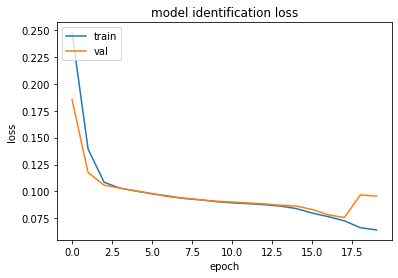

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model identification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

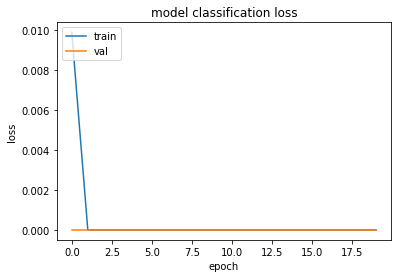

In [104]:
plt.plot(history.history['fc4_loss'])
plt.plot(history.history['val_fc4_loss'])
plt.title('model classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
!unzip -qq test.zip

In [105]:
from PIL import Image
from numpy import *
test = []
files = glob.glob ("test/blur/*.jpg")
for myFile in files:
    image = array(Image.open(myFile))
    test.append (image)
test = np.array(test) 
test= np.reshape(test,[test.shape[0],test.shape[1],test.shape[2],test.shape[3]])
np.save('test-blurry-images',test)

In [106]:
from PIL import Image
from numpy import *
test = []
files = glob.glob ("test/blur_label/*.jpg")
for myFile in files:
    image = array(Image.open(myFile))
    test.append (image)
test = np.array(test) 
test= np.reshape(test,[test.shape[0],test.shape[1],test.shape[2],test.shape[3]])
np.save('test-label-images',test)

In [107]:
from keras.models import load_model
from PIL import Image
images = np.load('test-blurry-images.npy')
images = images[0:100]
model = load_model("new_model.h5")
predictions=[]
for i in range(len(images)):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred[0])

In [108]:
predictions[0].shape

(1, 224, 224, 3)

In [109]:
((predictions[0])[0]).shape

(224, 224, 3)

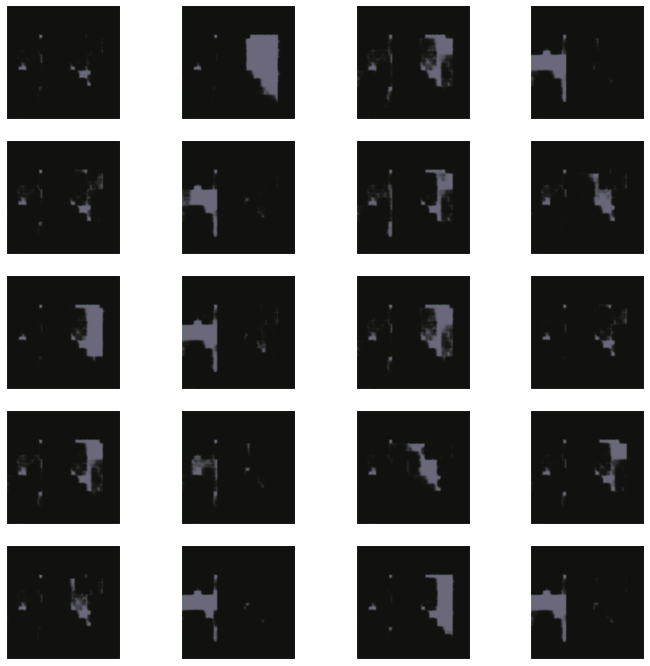

In [110]:
fig = plt.figure(figsize=(12,12))
columns = 4
rows = 5
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow((((predictions[i])[0])*255.0).astype(np.uint8))
  #plt.title('image')
  plt.axis("off")
plt.show()

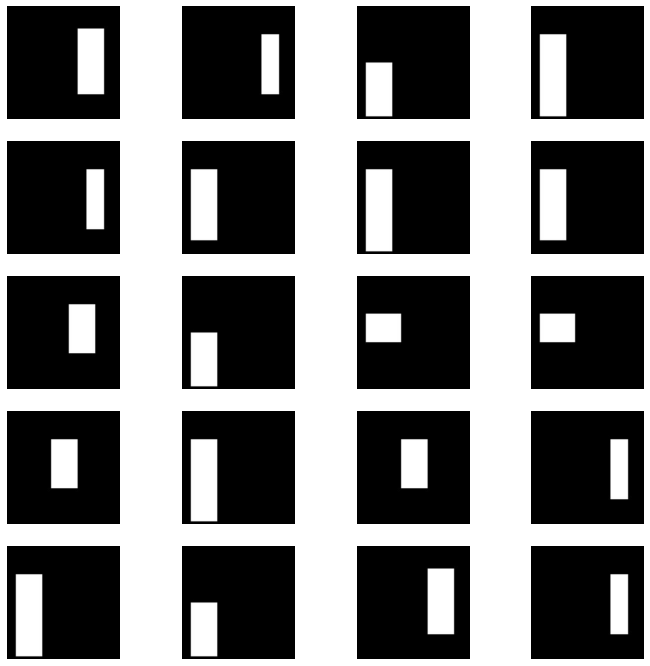

In [111]:
images = np.load('test-label-images.npy')
images = images[0:100]
fig = plt.figure(figsize=(12,12))
columns = 4
rows = 5
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(images[i],cmap='binary')
  #plt.title('image')
  plt.axis("off")
plt.show()

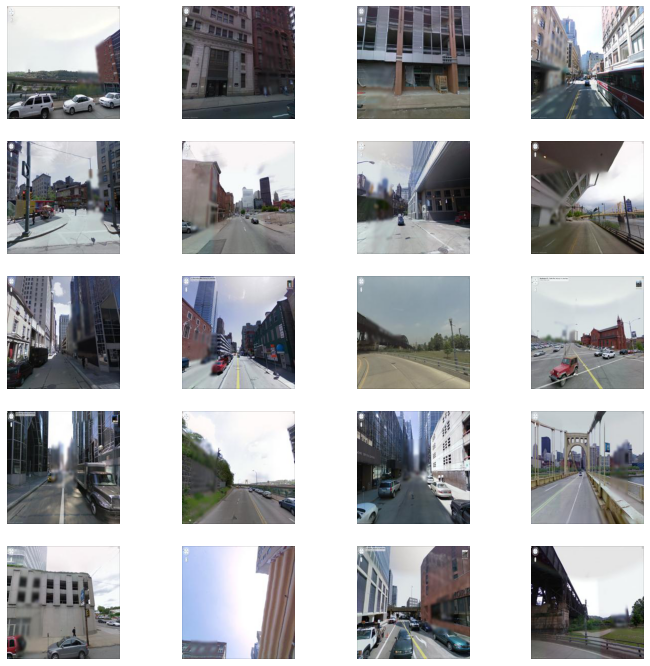

In [112]:
images = np.load('test-blurry-images.npy')
images = images[0:100]
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(images[i],cmap='binary')
  plt.axis("off")
plt.show()